# CS109b Final Project: 
# Air Pollution Exposure and COVID-19 Mortality in the U.S.

## Import libraries

In [1]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import plotly.figure_factory as ff

pd.options.display.max_rows = 500
pd.options.display.max_columns = 500

## Load and clean data

In [2]:
data = pd.read_csv("./../PM_COVID-master/processed_data_05-03-2020.csv")

In [3]:
#load data
#data = pd.read_csv('https://raw.githubusercontent.com/CS109b-Team37/Pollution-Prediction/master/PM_COVID-master/processed_data_04-24-2020.csv')

In [4]:
#rename older_pecent to older_percent
data = data.rename(columns={'older_pecent': 'older_percent'})

#drop columns
cols = list(data.columns)
cols.remove('Unnamed: 0') #just a column of integers 1-21560
#cols.remove('Province_State') #redundant information; already captured by 'state'
cols.remove('Country_Region') #only US
cols.remove('Combined_Key') #redundant information; already captured by 'Province_State' and 'Admin2'
cols.remove('year.x') #only 2016
cols.remove('year.y') #only 2012 and nan
cols.remove('Population') #'older_pecent' was calculated by Population/older_Population
cols.remove('older_Population') #'older_pecent' was calculated by Population/older_Population
cols.remove('date') #only 20200502
cols.remove('hash') #useless information
cols.remove('dateChecked') #only '2020-05-02T20:00:00Z'
cols.remove('Abbrev') #redundant information; already captured by 'state'
cols.remove('total') #almost a repeat of 'totalTestResults'
cols.remove('Recovered') #only 0
data = data[cols]


In [5]:
data['Last_Update'].unique()

array(['2020-05-04 02:32:28', '3/30/20 22:52'], dtype=object)

In [6]:
#convert Last_Update to binary variable
convert_dict = {'2020-05-04 02:32:28': 0, '3/30/20 22:52': 1}
data = data.replace({'Last_Update': convert_dict})


In [7]:
#variables with NA values
print('Variables with NA values:')
display(data.isna().sum()[data.isna().sum() > 0])

#remove variables with many NA values
na_vars = list(data.isna().sum()[data.isna().sum() > 50].index) #variables with many NA values
data = data[set(cols) - set(na_vars)] #final cleaned data

Variables with NA values:


smoke_rate                 867
mean_bmi                   867
Crude.Rate                   1
older_percent                1
pending                   2798
hospitalizedCurrently      719
hospitalizedCumulative    1276
inIcuCurrently            1783
inIcuCumulative           2345
onVentilatorCurrently     1953
onVentilatorCumulative    2839
recovered                 1074
hospitalized              1276
beds                       811
dtype: int64

In [8]:
#both NA values are for Loving, Texas
null_data = data[data.isnull().any(axis=1)]
print('Rows with NA values:')
display(null_data)

#fill in NA values for 'Crude.Rate' and 'older_percent' with state average
values = {'Crude.Rate': data.groupby('state').mean()['Crude.Rate']['TX'], 'older_percent': data.groupby('state').mean()['older_percent']['TX']}
data = data.fillna(value=values)

Rows with NA values:


,fips,older_percent,Last_Update,state,Admin2,mean_winter_temp,Confirmed,totalTestResults,pct_blk,positive,poverty,population_frac_county,Active,totalTestResultsIncrease,hospitalizedIncrease,positiveIncrease,Deaths,Long_,q_popdensity,mean_summer_rm,Crude.Rate,pct_owner_occ,negative,medhouseholdincome,pct_native,death,education,medianhousevalue,mean_winter_rm,population,popdensity,pct_white,mean_pm25,posNeg,mean_summer_temp,Province_State,negativeIncrease,pct_asian,deathIncrease,Lat,hispanic,totalTestResults_county
2635,48301,NaN,1,TX,Loving,290.213523,0,390560,0.0,31548,0.631579,0.000002,0,9912,0,1026,0,-103.581857,1,73.844694,NaN,0.485714,359012,55625.0,0.047619,867,0.526316,89040.0,72.837808,63,0.395035,0.857143,5.685412,390560,309.483185,Texas,8886,0.0,20,31.849476,0.142857,0.91409


## Modeling

In [9]:
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend
from tensorflow.keras import Model, Sequential
from tensorflow.keras.models import model_from_json
from tensorflow.keras.layers import Input, SimpleRNN, Dense, TimeDistributed, GRU, \
                          Dropout, Bidirectional, Conv1D, BatchNormalization

print('tensorflow version', tf.__version__)
print('keras version', tf.keras.__version__)

tensorflow version 2.0.0
keras version 2.2.4-tf


### Prepare data; split states into two groups (high testing and low testing)

In [10]:
#remove posNeg, since it is the same as totalTestResults
cols = list(data.columns)
cols.remove('posNeg') 
cols.remove('Deaths') #remove deaths because we are trying to predict cases
cols.remove('death')
cols.remove('fips')
cols.remove('state') #redundant, given Province_State
cols.remove('Admin2') #county names
dataTH = data[cols]


In [11]:
#load tests data
#directly from https://www.vox.com/2020/3/26/21193848/coronavirus-us-cases-deaths-tests-by-state (5/5/2020)
#which got the data from COVID Tracking Project, Census Bureau
tests_data = pd.read_csv("./../tests_data.csv")


In [12]:
#subset data to only include the 49 states in our dataset
states_in_data = dataTH['Province_State'].unique()
tests_data_sub = tests_data.loc[tests_data['state'].isin(states_in_data)]

#remove DC from the dataset because our data only has one observation for DC
tests_data_sub = tests_data_sub[tests_data_sub['state'] != 'District of Columbia']

#examine dataset
tests_data_sub.sort_values(by='tests_per_thousand_people', ascending=False)

,state,confirmed_cases,deaths,tests_conducted,tests_per_million_people,tests_per_thousand_people
55,Rhode Island,9477,320,71927,67897,67.897
54,New York,316415,19189,985911,50680,50.680
53,Massachusetts,68087,4004,314646,45650,45.650
52,North Dakota,1191,25,33353,43767,43.767
51,Utah,5175,50,122102,38086,38.086
50,Louisiana,29340,1969,176160,37894,37.894
49,New Mexico,3732,139,74944,35742,35.742
47,New Jersey,126744,7871,275707,31040,31.040
46,Tennessee,13177,210,204607,29961,29.961
44,West Virginia,1191,50,51638,28813,28.813


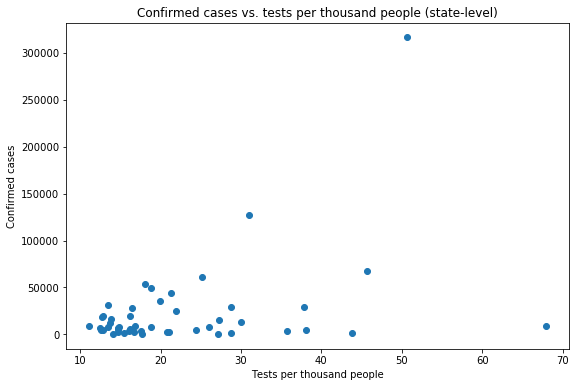

In [13]:
#states that conduct more testing have more confirmed cases
fig, ax = plt.subplots(1, 1, figsize = (9, 6))
ax.scatter(tests_data_sub['tests_per_thousand_people'], tests_data_sub['confirmed_cases'])
ax.set_title('Confirmed cases vs. tests per thousand people (state-level)')
ax.set_xlabel('Tests per thousand people')
ax.set_ylabel('Confirmed cases');

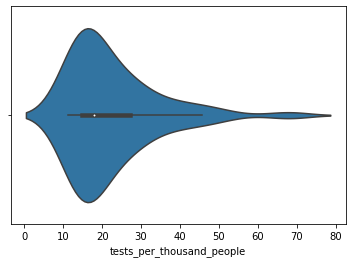

In [14]:
#plot distribution of tests_per_thousand_people; find cutoff

#ax = sns.distplot(tests_data_sub['tests_per_thousand_people']) #histogram
#ax = sns.boxplot(x=tests_data_sub['tests_per_thousand_people']) #boxplot
ax = sns.violinplot(x=tests_data_sub['tests_per_thousand_people']) #violinplot

In [15]:
#divide states into states that have high testing and states that have low testing

threshold = np.median(tests_data_sub['tests_per_thousand_people'])
#threshold = np.quantile(tests_data_sub['tests_per_thousand_people'], 0.25)
states_high = tests_data_sub[tests_data_sub['tests_per_thousand_people'] >= threshold].state.values
states_low = tests_data_sub[tests_data_sub['tests_per_thousand_people'] < threshold].state.values

#split data based on these two groups
states_high_data = dataTH.loc[dataTH['Province_State'].isin(states_high)]
states_low_data = dataTH.loc[dataTH['Province_State'].isin(states_low)]

print('Number of states with high levels of testing:', len(states_high))
print('Number of states with low levels of testing:', len(states_low))

Number of states with high levels of testing: 24
Number of states with low levels of testing: 24


In [16]:
#train model on states that have high testing
#once model is fully developed, apply it to states that have low testing

###data for states with high testing
X_high = states_high_data.loc[:, states_high_data.columns != 'Confirmed']
X_high = X_high.loc[:, X_high.columns != 'Province_State'] #remove states column; need to remove at this step and not earlier because states were used to stratify data
y_high = states_high_data['Confirmed']
X_high_train, X_high_test, y_high_train, y_high_test = train_test_split(X_high, y_high, test_size=0.10, random_state=42) #split states_high_data into train and test sets

###data for states with low testing
X_low = states_low_data.loc[:, states_low_data.columns != 'Confirmed']
X_low = X_low.loc[:, X_low.columns != 'Province_State'] #remove states column; need to remove at this step and not earlier because states were used to stratify data
y_low = states_low_data['Confirmed']
X_low_train, X_low_test, y_low_train, y_low_test = train_test_split(X_low, y_low, test_size=0.10, random_state=42) #split states_high_data into train and test sets


In [51]:
###data for all states
X = dataTH.loc[:, dataTH.columns != 'Confirmed']
X = X.loc[:, X.columns != 'Province_State'] #remove states column; need to remove at this step and not earlier because states were used to stratify data
y = dataTH['Confirmed']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42) #split states_high_data into train and test sets


### Random forest

In [17]:
import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mean_squared_error
from itertools import product
from sklearn.model_selection import cross_val_score


##### Random forest model for all states

In [54]:
###tune n_trees and tree_depth using cross validation

#parameter values to test
np.random.seed(123)
n_trees_list = list(range(50, 301, 50))
tree_depth_list = list(range(5, 40, 5))
counter = 0

#create df to store cross validation results
RF_all_df = pd.DataFrame(list(product(n_trees_list, tree_depth_list)), columns=['n_trees_list', 'tree_depth_list'])

#perform cross validation and store results
for n_trees in n_trees_list:
    for tree_depth in tree_depth_list:
        #set up model; perform 5-fold CV
        RF = RandomForestClassifier(max_features='auto', n_estimators=n_trees, max_depth=tree_depth)
        ###model
        cv_scores = cross_val_score(estimator=RF, X=X_train, y=y_train, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
        #calculate results
        cv_mean_mse = cv_scores.mean() #average mse of all 5 folds
        cv_sd = np.std(cv_scores) #standard deviation of all 5 folds
        #store results in df
        RF_all_df.loc[(RF_all_df.n_trees_list == n_trees) & (RF_all_df.tree_depth_list == tree_depth), 'cv_mean_mse'] = cv_mean_mse
        RF_all_df.loc[(RF_all_df.n_trees_list == n_trees) & (RF_all_df.tree_depth_list == tree_depth), 'cv_sd'] = cv_sd
        counter+=1
        print(f'{counter}/{len(n_trees_list)*len(tree_depth_list)} complete')

#convert MSE values to positive (metric was neg_mean_squared_error)
RF_all_df['cv_mean_mse'] = np.abs(RF_all_df['cv_mean_mse'])


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



1/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



2/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



3/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



4/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



5/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



6/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



7/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



8/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



9/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



10/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



11/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



12/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



13/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



14/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



15/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



16/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



17/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



18/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



19/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



20/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



21/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



22/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



23/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



24/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



25/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



26/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



27/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



28/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



29/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



30/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



31/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



32/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



33/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



34/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



35/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



36/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



37/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



38/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



39/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



40/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



41/42 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



42/42 complete


In [58]:
RF_all_df

,n_trees_list,tree_depth_list,cv_mean_mse,cv_sd
0,50,5,1.418357e+07,2.254078e+07
1,50,10,2.119442e+07,2.367329e+07
2,50,15,1.274121e+07,2.153881e+07
3,50,20,1.096441e+07,1.896824e+07
4,50,25,1.071810e+07,1.906630e+07
5,50,30,3.380487e+07,4.635874e+07
6,50,35,1.124959e+07,1.881432e+07
7,100,5,2.071599e+07,2.278503e+07
8,100,10,1.229129e+07,1.912210e+07
9,100,15,2.988328e+07,2.340565e+07


In [62]:
### random forest model for states with high testing

#choose n_trees and tree_depth combination with the lowest difference between CV MSE and training set MSE (least overfit)
np.random.seed(123)
n_trees_best = int(RF_all_df.iloc[RF_all_df['cv_mean_mse'].idxmin()]['n_trees_list'])
tree_depth_best = int(RF_all_df.iloc[RF_all_df['cv_mean_mse'].idxmin()]['tree_depth_list'])
print('Random forest model, n_trees, determined by CV:', n_trees_best)
print('Random forest model, tree_depth, determined by CV:', tree_depth_best)

#train final random forest
RF = RandomForestClassifier(max_features='auto', n_estimators=n_trees_best, max_depth=tree_depth_best)
RF.fit(X_train, y_train)

#performance evaluation
pred_train = RF.predict(X_train)
pred_test = RF.predict(X_test)
print('Random forest, MSE, training set:', mean_squared_error(y_train, pred_train))
print('Random forest, MSE, test set:', mean_squared_error(y_test, pred_test))

#now that model is finalized, build model on all of the available data (all of states_high_data)
#RF_high_final = RandomForestClassifier(max_features='auto', n_estimators=n_trees_best, max_depth=tree_depth_best)
#RF_high_final.fit(X_high, y_high);

Random forest model, n_trees, determined by CV: 100
Random forest model, tree_depth, determined by CV: 35
Random forest, MSE, training set: 0.0
Random forest, MSE, test set: 1893380.3754045307


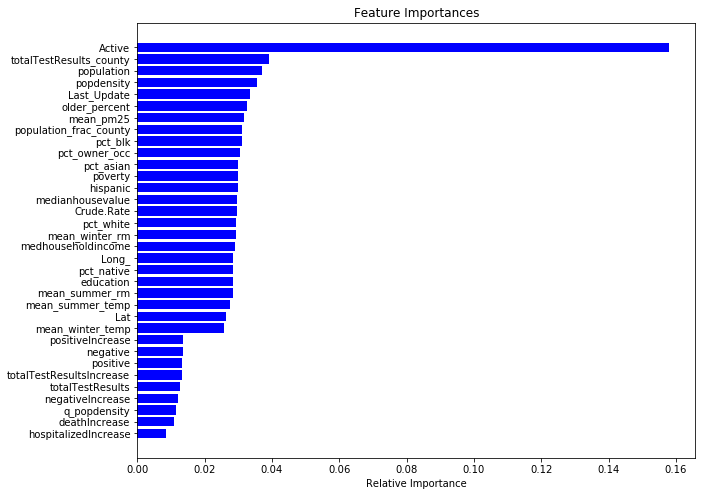

In [67]:
features = X_train.columns
importances = RF.feature_importances_
indices = np.argsort(importances)

plt.figure(figsize=(10,8))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance');

##### Random forest model for high states and low states

In [39]:
###tune n_trees and tree_depth using cross validation

#parameter values to test
np.random.seed(123)
n_trees_list = list(range(100, 501, 20))
tree_depth_list = list(range(5, 40, 5))
#n_trees_list = [10, 20]
#tree_depth_list = [10, 15]
counter = 0

#create df to store cross validation results
RF_df = pd.DataFrame(list(product(n_trees_list, tree_depth_list)), columns=['n_trees_list', 'tree_depth_list'])

#perform cross validation and store results
for n_trees in n_trees_list:
    for tree_depth in tree_depth_list:
        #set up model; perform 5-fold CV
        RF = RandomForestClassifier(max_features='auto', n_estimators=n_trees, max_depth=tree_depth)
        
        ###model for high states
        high_cv_scores = cross_val_score(estimator=RF, X=X_high_train, y=y_high_train, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
        #calculate results
        high_cv_mean_mse = high_cv_scores.mean() #average mse of all 5 folds
        high_cv_sd = np.std(high_cv_scores) #standard deviation of all 5 folds
        #store results in df
        RF_df.loc[(RF_df.n_trees_list == n_trees) & (RF_df.tree_depth_list == tree_depth), 'high_cv_mean_mse'] = high_cv_mean_mse
        RF_df.loc[(RF_df.n_trees_list == n_trees) & (RF_df.tree_depth_list == tree_depth), 'high_cv_sd'] = high_cv_sd
        
        ###model for low states
        low_cv_scores = cross_val_score(estimator=RF, X=X_low_train, y=y_low_train, scoring='neg_mean_squared_error', cv=5, n_jobs=-1)
        #calculate results
        low_cv_mean_mse = low_cv_scores.mean() #average mse of all 5 folds
        low_cv_sd = np.std(low_cv_scores) #standard deviation of all 5 folds
        #store results in df
        RF_df.loc[(RF_df.n_trees_list == n_trees) & (RF_df.tree_depth_list == tree_depth), 'low_cv_mean_mse'] = low_cv_mean_mse
        RF_df.loc[(RF_df.n_trees_list == n_trees) & (RF_df.tree_depth_list == tree_depth), 'low_cv_sd'] = low_cv_sd
        counter+=1
        print(f'{counter}/{len(n_trees_list)*len(tree_depth_list)} complete')

#convert MSE values to positive (metric was neg_mean_squared_error)
RF_df['high_cv_mean_mse'] = np.abs(RF_df['high_cv_mean_mse'])
RF_df['low_cv_mean_mse'] = np.abs(RF_df['low_cv_mean_mse'])


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



1/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



2/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



3/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



4/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



5/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



6/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



7/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



8/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



9/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



10/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



11/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



12/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



13/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



14/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



15/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



16/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



17/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



18/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



19/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



20/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



21/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



22/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



23/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



24/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



25/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



26/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



27/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



28/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



29/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



30/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



31/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



32/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



33/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



34/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



35/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



36/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



37/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



38/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



39/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



40/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



41/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



42/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



43/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



44/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



45/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



46/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



47/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



48/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



49/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



50/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



51/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



52/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



53/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



54/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



55/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



56/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



57/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



58/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



59/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



60/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



61/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



62/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



63/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



64/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



65/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



66/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



67/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



68/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



69/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



70/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



71/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



72/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



73/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



74/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



75/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



76/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



77/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



78/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



79/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



80/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



81/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



82/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



83/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



84/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



85/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



86/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



87/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



88/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



89/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



90/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



91/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



92/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



93/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



94/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



95/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



96/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



97/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



98/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



99/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



100/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



101/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



102/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



103/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



104/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



105/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



106/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



107/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



108/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



109/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



110/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



111/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



112/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



113/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



114/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



115/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



116/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



117/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



118/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



119/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



120/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



121/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



122/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



123/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



124/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



125/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



126/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



127/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



128/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



129/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



130/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



131/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



132/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



133/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



134/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



135/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



136/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



137/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



138/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



139/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



140/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



141/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



142/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



143/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



144/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



145/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



146/147 complete


//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.

//anaconda3/envs/cs109b/lib/python3.7/site-packages/sklearn/model_selection/_split.py:667: UserWarning:

The least populated class in y has only 1 members, which is less than n_splits=5.



147/147 complete


In [40]:
RF_df

,n_trees_list,tree_depth_list,high_cv_mean_mse,high_cv_sd,low_cv_mean_mse,low_cv_sd
0,100,5,6.307741e+07,6.650998e+07,157007.210892,61390.109220
1,100,10,7.441784e+07,6.031040e+07,135673.175074,78871.909067
2,100,15,5.777050e+07,6.152541e+07,105879.886235,48782.456802
3,100,20,3.246378e+07,4.854210e+07,109190.228094,54416.502033
4,100,25,2.884724e+07,5.005052e+07,74697.255932,44409.197490
5,100,30,2.883813e+07,4.967777e+07,113289.784480,50318.931293
6,100,35,4.444888e+07,5.378610e+07,94226.915350,37219.877355
7,120,5,6.505773e+07,6.776898e+07,160592.260686,89850.710612
8,120,10,9.125245e+07,7.235080e+07,123678.925105,63467.411225
9,120,15,3.646587e+07,6.417683e+07,106379.043490,53916.180160


In [41]:
### random forest model for states with high testing

#choose n_trees and tree_depth combination with the lowest difference between CV MSE and training set MSE (least overfit)
np.random.seed(123)
n_trees_best = int(RF_df.iloc[RF_df['high_cv_mean_mse'].idxmin()]['n_trees_list'])
tree_depth_best = int(RF_df.iloc[RF_df['high_cv_mean_mse'].idxmin()]['tree_depth_list'])
print('Random forest model for high states, n_trees, determined by CV:', n_trees_best)
print('Random forest model for high states, tree_depth, determined by CV:', tree_depth_best)

#train final random forest
RF_high = RandomForestClassifier(max_features='auto', n_estimators=n_trees_best, max_depth=tree_depth_best)
RF_high.fit(X_high_train, y_high_train)

#performance evaluation
pred_high_train = RF_high.predict(X_high_train)
pred_high_test = RF_high.predict(X_high_test)
print('Random forest, MSE, states with high testing, training set:', mean_squared_error(y_high_train, pred_high_train))
print('Random forest, MSE, states with high testing, test set:', mean_squared_error(y_high_test, pred_high_test))

#now that model is finalized, build model on all of the available data (all of states_high_data)
RF_high_final = RandomForestClassifier(max_features='auto', n_estimators=n_trees_best, max_depth=tree_depth_best)
RF_high_final.fit(X_high, y_high);

Random forest model for high states, n_trees, determined by CV: 300
Random forest model for high states, tree_depth, determined by CV: 35
Random forest, MSE, states with high testing, training set: 0.0
Random forest, MSE, states with high testing, test set: 342636.83928571426


In [42]:
### random forest model for states with low testing

#choose n_trees and tree_depth combination with the lowest difference between CV MSE and training set MSE (least overfit)
np.random.seed(123)
n_trees_best = int(RF_df.iloc[RF_df['low_cv_mean_mse'].idxmin()]['n_trees_list'])
tree_depth_best = int(RF_df.iloc[RF_df['low_cv_mean_mse'].idxmin()]['tree_depth_list'])
print('Random forest model for low states, n_trees, determined by CV:', n_trees_best)
print('Random forest model for low states, tree_depth, determined by CV:', tree_depth_best)

#train final random forest
RF_low = RandomForestClassifier(max_features='auto', n_estimators=n_trees_best, max_depth=tree_depth_best)
RF_low.fit(X_low_train, y_low_train)

#performance evaluation
pred_low_train = RF_low.predict(X_low_train)
pred_low_test = RF_low.predict(X_low_test)
print('Random forest, MSE, states with low testing, training set:', mean_squared_error(y_low_train, pred_low_train))
print('Random forest, MSE, states with low testing, test set:', mean_squared_error(y_low_test, pred_low_test))

#now that model is finalized, build model on all of the available data (all of states_low_data)
RF_low_final = RandomForestClassifier(max_features='auto', n_estimators=n_trees_best, max_depth=tree_depth_best)
RF_low_final.fit(X_low, y_low);

Random forest model for low states, n_trees, determined by CV: 100
Random forest model for low states, tree_depth, determined by CV: 25
Random forest, MSE, states with low testing, training set: 0.0
Random forest, MSE, states with low testing, test set: 67171.67005076142


##### Investigate question

In [43]:
#use high states model to predict cases in low states
cross_pred_lowstates = RF_high_final.predict(X_low)
print('Prediction of cases in states with low testing, using high states model:', mean_squared_error(y_low, cross_pred_lowstates))

#use low states model to predict cases in high states
cross_pred_highstates = RF_low_final.predict(X_high)
print('Prediction of cases in states with high testing, using low states model:', mean_squared_error(y_high, cross_pred_highstates))


Prediction of cases in states with low testing, using high states model: 437294.1686135094
Prediction of cases in states with high testing, using low states model: 34824847.7625448


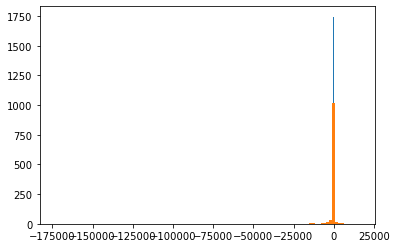

In [50]:
#examine distributions
plt.hist(cross_pred_lowstates - y_low, bins=100)

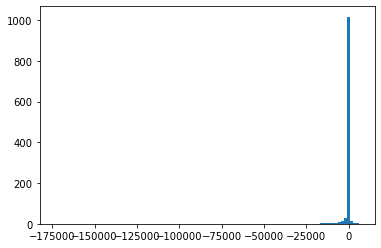

In [68]:
plt.hist(cross_pred_highstates - y_high, bins=100);

In [83]:
sum((cross_pred_lowstates - y_low) <= 0)/len(y_low)

0.7958354494667343

In [85]:
sum((cross_pred_highstates - y_high) >= 0)/len(y_high)

0.492831541218638

### Feedforward NN

In [ ]:
#set parameters
n_units = 10
drop_rate = 0.1
optimizer = tf.keras.optimizers.Adam(lr = 0.0001)
loss = 'mse'
#metrics = ['accuracy']


#define model
model = tf.keras.Sequential()
model.add(tf.keras.layers.Dense(n_units, activation = 'relu', input_shape = (34,)))
#model.add(tf.keras.layers.Dropout(drop_rate))
model.add(tf.keras.layers.Dense(n_units, activation='relu'))
#model.add(tf.keras.layers.Dropout(drop_rate))
model.add(tf.keras.layers.Dense(n_units, activation='relu'))
#model.add(tf.keras.layers.Dropout(drop_rate))
model.add(tf.keras.layers.Dense(1, activation='relu'))

# Compile model
model.compile(optimizer=optimizer, loss=loss)
model.summary()

In [ ]:
#!!!!!try scaling data better

In [ ]:
batch_size = 16
epochs = 30
validation_split = 0.1
verbose = 1

history = model.fit(np.asarray(X_train), np.asarray(y_train), epochs=epochs, batch_size=batch_size, validation_split=validation_split, 
                    verbose=verbose)


In [ ]:
#save model
#model.save('saved_models/model')

#load model
#model = tf.keras.models.load_model('saved_models/model')

In [ ]:
#plot acccruacies

def plot_loss_vs_epoch(history, title):
    fig, ax = plt.subplots(1, 1, figsize = (8, 5))
    ax.plot(history['loss'], label = 'Train')
    ax.plot(history['val_loss'], label = 'Validation')
    ax.set_xlabel('Epoch', size = 13)
    ax.set_ylabel('Loss', size = 13)
    ax.set_title(title, size = 13)
    ax.legend(fontsize = 13)
    
#plot loss vs. epochs
plot_loss_vs_epoch(history.history, 'Model Training: Loss vs. Epochs')

In [ ]:
#model predictions

#predict states_high training set
pred_stateshigh_train = model.predict(np.asarray(X_train))

#predict states_high test set
pred_stateshigh_test

#predict states_low
pred_stateslow

#test model on states_low_data

#check that states_high and states_low have similar distributions
#check model performance with and without pm2.5 levels